Implemente os classificadores k-NN, com e sem peso, e o k-NN adaptativo; use distância Euclidiana. Avalie os três classificadores em duas bases de dados do repositório Promise (ver link abaixo). Essas bases devem conter apenas atributos numéricos. Varie o parâmetro k = {1,2,3,5,7,9,11,13,15} e construa um gráfico que mostre o comportamento da taxa de acerto à medida que o valor de k muda para os três classificadores. Analise os resultados em relação ao tempo de processamento e à taxa de acerto, e construa uma argumentação que indique as melhores escolhas para as bases de dados avaliadas. (dica: observe o valor de k, o acerto/erro por classe, o tempo de treinamento e o tempo de teste).

Promise repository: http://promise.site.uottawa.ca/SERepository/datasets-page.html. Na avaliação dos algoritmos, use o k-fold cross-validation. O relatório deve conter informações de forma que seja possível replicar os experimentos (metodologia dos experimentos), além dos resultados e suas análises.

In [80]:
import pandas as pd
import numpy as np
kc1Dataset = pd.read_csv('datasets/kc1.csv')
kc1Dataset.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65,10,6,0,18.0,25.0,107.0,64.0,21.0,True
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37,2,5,0,16.0,28.0,89.0,52.0,15.0,True
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21,0,2,0,11.0,10.0,41.0,17.0,5.0,True


In [81]:
# tratando os dados
kc1Dataset['problems'] = kc1Dataset['problems'].astype(int)
kc1Dataset.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,0
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65,10,6,0,18.0,25.0,107.0,64.0,21.0,1
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37,2,5,0,16.0,28.0,89.0,52.0,15.0,1
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21,0,2,0,11.0,10.0,41.0,17.0,5.0,1


In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import KFold
from sklearn.model_selection import cross_val_score
import time

variacoes_k = [1,2,3,5,7,9,11,13,15]
SEED = 5
np.random.seed(SEED)
x = kc1Dataset.loc[:, kc1Dataset.columns != 'problems']
y = kc1Dataset['problems']

# prepara o procedimento cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.4,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 1265 elementos e testaremos com 844 elementos


In [83]:
taxasAcertoSemPeso = pd.DataFrame(columns=['k', 'acuracia'])
for k in variacoes_k:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')

    inicioTreino = time.time()
    neigh.fit(treino_x, treino_y)
    fimTreino = time.time()
    tempoTreino = fimTreino - inicioTreino

    inicioTeste = time.time()
    previsoes = neigh.predict(teste_x)
    fimTeste = time.time()
    tempoTeste = fimTeste - inicioTeste

    #calculando a acuracia
    acuracia = np.mean(cross_val_score(neigh, teste_x, teste_y, cv=cv))
    print(f"A acurácia com k={k} foi %.2f%%" % (acuracia * 100))
    print("Tempo de treino: %.4g s" % tempoTreino)
    print("Tempo de teste: %.4g s" % tempoTeste)
    taxasAcertoSemPeso.loc[k] = [k, acuracia]

A acurácia com k=1 foi 81.28%
Tempo de treino: 0.001973 s
Tempo de teste: 0.06698 s
A acurácia com k=2 foi 84.48%
Tempo de treino: 0.003074 s
Tempo de teste: 0.09812 s
A acurácia com k=3 foi 83.07%
Tempo de treino: 0.002983 s
Tempo de teste: 0.08438 s
A acurácia com k=5 foi 84.37%
Tempo de treino: 0.0031 s
Tempo de teste: 0.08594 s
A acurácia com k=7 foi 84.84%
Tempo de treino: 0.003104 s
Tempo de teste: 0.08308 s
A acurácia com k=9 foi 83.89%
Tempo de treino: 0.003046 s
Tempo de teste: 0.08507 s
A acurácia com k=11 foi 83.89%
Tempo de treino: 0.002958 s
Tempo de teste: 0.08596 s
A acurácia com k=13 foi 84.83%
Tempo de treino: 0.002916 s
Tempo de teste: 0.0839 s
A acurácia com k=15 foi 84.60%
Tempo de treino: 0.003263 s
Tempo de teste: 0.08289 s


       k  acuracia
1    1.0  0.812773
2    2.0  0.844790
3    3.0  0.830658
5    5.0  0.843683
7    7.0  0.848375
9    9.0  0.838908
11  11.0  0.838880
13  13.0  0.848347
15  15.0  0.846008


Text(0, 0.5, 'Acurácia')

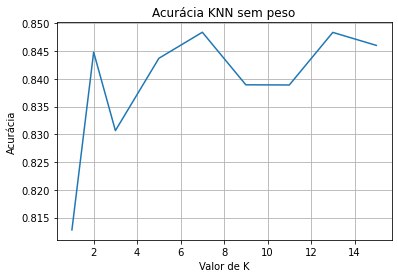

In [84]:
import matplotlib.pyplot as plt

print(taxasAcertoSemPeso)
plt.plot(taxasAcertoSemPeso['k'],taxasAcertoSemPeso['acuracia'])
plt.title("Acurácia KNN sem peso")
plt.grid(True)
plt.xlabel("Valor de K")
plt.ylabel("Acurácia")

In [85]:
taxasAcertoComPeso = pd.DataFrame(columns=['k', 'acuracia'])
for k in variacoes_k:
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    inicioTreino = time.time()
    neigh.fit(treino_x, treino_y)
    fimTreino = time.time()
    tempoTreino = fimTreino - inicioTreino

    inicioTeste = time.time()
    previsoes = neigh.predict(teste_x)
    fimTeste = time.time()
    tempoTeste = fimTeste - inicioTeste

    #calculando a acuracia
    acuracia = np.mean(cross_val_score(neigh, teste_x, teste_y, cv=cv))
    print(f"A acurácia com k={k} foi %.2f%%" % (acuracia * 100))
    print("Tempo de treino: %.4g s" % tempoTreino)
    print("Tempo de teste: %.4g s" % tempoTeste)
    taxasAcertoComPeso.loc[k] = [k, acuracia]

A acurácia com k=1 foi 81.28%
Tempo de treino: 0.001753 s
Tempo de teste: 0.02607 s
A acurácia com k=2 foi 81.75%
Tempo de treino: 0.002951 s
Tempo de teste: 0.03326 s
A acurácia com k=3 foi 82.82%
Tempo de treino: 0.002957 s
Tempo de teste: 0.03358 s
A acurácia com k=5 foi 83.30%
Tempo de treino: 0.00293 s
Tempo de teste: 0.04046 s
A acurácia com k=7 foi 83.65%
Tempo de treino: 0.002974 s
Tempo de teste: 0.04182 s
A acurácia com k=9 foi 83.30%
Tempo de treino: 0.002921 s
Tempo de teste: 0.0415 s
A acurácia com k=11 foi 83.18%
Tempo de treino: 0.002898 s
Tempo de teste: 0.03735 s
A acurácia com k=13 foi 83.06%
Tempo de treino: 0.002989 s
Tempo de teste: 0.04257 s
A acurácia com k=15 foi 83.77%
Tempo de treino: 0.002993 s
Tempo de teste: 0.04214 s


       k  acuracia
1    1.0  0.812773
2    2.0  0.817507
3    3.0  0.828249
5    5.0  0.832955
7    7.0  0.836527
9    9.0  0.832955
11  11.0  0.831765
13  13.0  0.830588
15  15.0  0.837689


Text(0, 0.5, 'Acurácia')

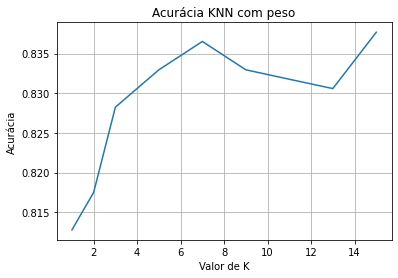

In [86]:
import matplotlib.pyplot as plt

print(taxasAcertoComPeso)
plt.plot(taxasAcertoComPeso['k'],taxasAcertoComPeso['acuracia'])
plt.title("Acurácia KNN com peso")
plt.grid(True)
plt.xlabel("Valor de K")
plt.ylabel("Acurácia")